## Sanity Test

In [1]:
import h5py
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pennylane as qml

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and preprocess data
jet_images_path = '../../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
with h5py.File(jet_images_path, 'r') as jet_mass_data:
    X_jet = jet_mass_data['image']
    print("Original shape:", X_jet.shape)
    X_jet = np.array(X_jet)
    X_jet = torch.tensor(X_jet, dtype=torch.float32)

# Normalize and resize images
X_jet = (X_jet - X_jet.min()) / (X_jet.max() - X_jet.min())
X_jet = X_jet.unsqueeze(1)
X_jet_resized = nn.functional.interpolate(X_jet, size=(16, 16), mode='bilinear', align_corners=False)
print("Resized shape:", X_jet_resized.shape)

# Sample data
indices = random.sample(range(X_jet_resized.shape[0]), 10000)
X_jet_sampled = X_jet_resized[indices]
print("Sampled shape:", X_jet_sampled.shape)

# Flatten images and apply PCA
X_flat = X_jet_sampled.view(-1, 256).numpy()
n_components = 8
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_flat)

# Create dataset and dataloader
class JetDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

dataset = JetDataset(X_pca)
batch_size = 64
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define quantum devices
n_qubits = n_components
n_layers = 3
dev_generator = qml.device('default.qubit', wires=n_qubits)
dev_discriminator = qml.device('default.qubit', wires=n_qubits)


Original shape: (872666, 25, 25)
Resized shape: torch.Size([872666, 1, 16, 16])
Sampled shape: torch.Size([10000, 1, 16, 16])


In [2]:
@qml.qnode(dev_generator, interface='torch')
def generator_qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

@qml.qnode(dev_discriminator, interface='torch')
def discriminator_qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

# Define weight shapes for the models
generator_weight_shapes = {"weights": (n_layers, n_qubits, 3)}
discriminator_weight_shapes = {"weights": (n_layers, n_qubits, 3)}

# Create the generator and discriminator models
generator = qml.qnn.TorchLayer(generator_qnode, generator_weight_shapes).to(device)
discriminator = qml.qnn.TorchLayer(discriminator_qnode, discriminator_weight_shapes).to(device)

# Define optimizers and loss function
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.01)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Training loop
num_epochs = 30
d_losses = []
g_losses = []

In [3]:
for epoch in range(num_epochs):
    for i, real_data in enumerate(dataloader):
        batch_size = real_data.size(0)
        real_data = real_data.to(device)

        # Train Discriminator
        d_optimizer.zero_grad()
        # Real data
        real_labels = torch.ones(batch_size).to(device)  # Changed shape to [batch_size]
        real_output = discriminator(real_data)
        real_output = (real_output + 1)/2  # Map to [0,1]
        d_loss_real = criterion(real_output, real_labels)

        # Fake data
        noise = torch.randn(batch_size, n_qubits).to(device)
        fake_data = generator(noise)
        fake_data = fake_data.detach()
        fake_output = discriminator(fake_data)
        fake_output = (fake_output + 1)/2  # Map to [0,1]
        fake_labels = torch.zeros(batch_size).to(device)  # Changed shape to [batch_size]
        d_loss_fake = criterion(fake_output, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        noise = torch.randn(batch_size, n_qubits).to(device)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data)
        fake_output = (fake_output + 1)/2  # Map to [0,1]
        g_loss = criterion(fake_output, real_labels)  # Try to fool discriminator
        g_loss.backward()
        g_optimizer.step()

        # Save losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

Epoch [1/30], d_loss: 1.3990, g_loss: 0.7029
Epoch [2/30], d_loss: 1.3896, g_loss: 0.6844
Epoch [3/30], d_loss: 1.4129, g_loss: 0.6774
Epoch [4/30], d_loss: 1.4040, g_loss: 0.6616
Epoch [5/30], d_loss: 1.3738, g_loss: 0.6821
Epoch [6/30], d_loss: 1.3965, g_loss: 0.7021
Epoch [7/30], d_loss: 1.3859, g_loss: 0.6748
Epoch [8/30], d_loss: 1.3915, g_loss: 0.6966
Epoch [9/30], d_loss: 1.3715, g_loss: 0.7154
Epoch [10/30], d_loss: 1.3858, g_loss: 0.6952
Epoch [11/30], d_loss: 1.3922, g_loss: 0.6767
Epoch [12/30], d_loss: 1.3870, g_loss: 0.6858
Epoch [13/30], d_loss: 1.3906, g_loss: 0.6381
Epoch [14/30], d_loss: 1.3816, g_loss: 0.6759
Epoch [15/30], d_loss: 1.3840, g_loss: 0.7178
Epoch [16/30], d_loss: 1.3861, g_loss: 0.6977
Epoch [17/30], d_loss: 1.3913, g_loss: 0.6645
Epoch [18/30], d_loss: 1.3621, g_loss: 0.6901
Epoch [19/30], d_loss: 1.3872, g_loss: 0.7138
Epoch [20/30], d_loss: 1.3527, g_loss: 0.6970
Epoch [21/30], d_loss: 1.3946, g_loss: 0.7062
Epoch [22/30], d_loss: 1.4046, g_loss: 0.69

## Perceptual-Quantum Loss

Since we are working with quantum data, we want to balance two key objectives during training:

1. **Image Quality**: Ensuring that the generated images are perceptually similar to real images.
2. **Quantum Fidelity**: Ensuring that the quantum states of the generated data resemble those of the real data.

To achieve this balance, we introduce a combined loss function known as **Perceptual Quantum Loss**.

#### **1. Perceptual Loss**

The **Perceptual Loss** is used to measure the similarity between real and generated images based on high-level features extracted from a pre-trained network (like **VGG16**). Instead of comparing images at the pixel level, the perceptual loss compares features from deeper layers of the network, capturing more abstract patterns like edges, textures, and shapes. This ensures that the generated images are perceptually similar to real ones.

The pre-trained network (VGG16) acts as a "feature extractor" for this comparison. We resize the generated images and real images to match the input size of VGG16, extract their features, and compute the mean squared error (MSE) between these features. Lower perceptual loss indicates that the generated images look more like the real images.

#### **2. Quantum Fidelity**

Since we are working with quantum data, we also need to ensure that the quantum states of the generated data closely match those of the real data. **Quantum Fidelity** measures the similarity between two quantum states. Higher fidelity means that the quantum states are more similar, indicating that the generator is learning to produce data that is not only visually accurate but also quantum-accurate.

In our implementation, we encode both real and generated data into quantum circuits and compute the fidelity between the quantum states.

#### **3. Combined Loss Function**

The **Perceptual Quantum Loss** combines these two components:

$$
L_{\text{total}} = L_{\text{adversarial}} + \alpha \times L_{\text{perceptual}} - \beta \times L_{\text{fidelity}}
$$

- **Adversarial Loss (`L_adversarial`)**: This is the standard GAN loss that drives the generator to produce images that fool the discriminator.
- **Perceptual Loss (`L_perceptual`)**: Encourages the generator to produce images that are perceptually similar to real images.
- **Quantum Fidelity (`L_fidelity`)**: Ensures that the quantum states of generated data match those of the real data.

Here, `alpha` controls the importance of the perceptual loss, and `beta` controls the importance of quantum fidelity. By adjusting these hyperparameters, we can fine-tune the balance between visual similarity and quantum state similarity.

#### **Why Use Perceptual Quantum Loss?**

In Quantum GANs, we aim to generate data that is accurate in two domains:
- **Visual domain**: Ensuring that the images look like real images.
- **Quantum domain**: Ensuring that the quantum data respects the underlying quantum structure.

Perceptual Quantum Loss allows us to address both goals in a single loss function, making it a powerful tool for training Quantum GANs to generate realistic data while maintaining quantum properties.


In [8]:
import h5py
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pennylane as qml
from torchvision import models, transforms
from skimage.metrics import structural_similarity as ssim
import pandas as pd

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load and preprocess data
# jet_images_path = 'jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
# with h5py.File(jet_images_path, 'r') as jet_mass_data:
#     X_jet = jet_mass_data['image']
#     print("Original shape:", X_jet.shape)
#     X_jet = np.array(X_jet)
#     X_jet = torch.tensor(X_jet, dtype=torch.float32)

# # Normalize and resize images
# X_jet = (X_jet - X_jet.min()) / (X_jet.max() - X_jet.min())
# X_jet = X_jet.unsqueeze(1)
# X_jet_resized = nn.functional.interpolate(X_jet, size=(16, 16), mode='bilinear', align_corners=False)
# print("Resized shape:", X_jet_resized.shape)

# # Sample data
# indices = random.sample(range(X_jet_resized.shape[0]), 10000)
# X_jet_sampled = X_jet_resized[indices]
# print("Sampled shape:", X_jet_sampled.shape)

In [10]:
jet_images_path = '../../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'

with h5py.File(jet_images_path, 'r') as jet_mass_data:
    X_jet = jet_mass_data['image']
    print("Original shape:", X_jet.shape)
    X_jet = np.array(X_jet)
    X_jet = torch.tensor(X_jet, dtype=torch.float32)

# Normalize and resize images
X_jet = (X_jet - X_jet.min()) / (X_jet.max() - X_jet.min())
X_jet = X_jet.unsqueeze(1)
X_jet_resized = nn.functional.interpolate(X_jet, size=(16, 16), mode='bilinear', align_corners=False)
print("Resized shape:", X_jet_resized.shape)

# Sample data
indices = random.sample(range(X_jet_resized.shape[0]), 10000)
X_jet_sampled = X_jet_resized[indices]
print("Sampled shape:", X_jet_sampled.shape)

Original shape: (872666, 25, 25)
Resized shape: torch.Size([872666, 1, 16, 16])
Sampled shape: torch.Size([10000, 1, 16, 16])


In [11]:
# Flatten images and apply PCA
X_flat = X_jet_sampled.view(-1, 256).numpy()
n_components = 8
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_flat)

# Create dataset and dataloader
class JetDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

dataset = JetDataset(X_pca)
batch_size = 64
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define quantum devices
n_qubits = n_components
n_layers = 3
dev_generator = qml.device('default.qubit', wires=n_qubits)
dev_discriminator = qml.device('default.qubit', wires=n_qubits)

# Define the generator and discriminator quantum circuits
@qml.qnode(dev_generator, interface='torch')
def generator_qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

@qml.qnode(dev_discriminator, interface='torch')
def discriminator_qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))


In [12]:
# Define weight shapes for the models
generator_weight_shapes = {"weights": (n_layers, n_qubits, 3)}
discriminator_weight_shapes = {"weights": (n_layers, n_qubits, 3)}

# Create the generator and discriminator models
generator = qml.qnn.TorchLayer(generator_qnode, generator_weight_shapes).to(device)
discriminator = qml.qnn.TorchLayer(discriminator_qnode, discriminator_weight_shapes).to(device)

# Define optimizers and loss function
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.01)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Load pre-trained VGG16 model for perceptual loss
vgg = models.vgg16(pretrained=True).features[:8].eval().to(device)
# Freeze VGG parameters
for param in vgg.parameters():
    param.requires_grad = False

# Define image preprocessing for VGG
vgg_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Normalization parameters for VGG
])

# Function to compute perceptual loss
def perceptual_loss(real_images, fake_images):
    # Both inputs are in PCA space, need to inverse transform and reshape
    real_images = pca.inverse_transform(real_images.cpu().numpy())
    fake_images = pca.inverse_transform(fake_images.cpu().detach().numpy())

    real_images = torch.tensor(real_images, dtype=torch.float32).view(-1, 1, 16, 16).to(device)
    fake_images = torch.tensor(fake_images, dtype=torch.float32).view(-1, 1, 16, 16).to(device)

    # Upsample images to 224x224 and replicate channels to match VGG input
    real_images = F.interpolate(real_images, size=(224, 224), mode='bilinear', align_corners=False)
    fake_images = F.interpolate(fake_images, size=(224, 224), mode='bilinear', align_corners=False)
    real_images = real_images.repeat(1, 3, 1, 1)  # Convert to 3 channels
    fake_images = fake_images.repeat(1, 3, 1, 1)

    # Normalize images
    real_images = vgg_transform(real_images)
    fake_images = vgg_transform(fake_images)

    # Extract features
    real_features = vgg(real_images)
    fake_features = vgg(fake_images)

    # Compute perceptual loss
    loss = F.mse_loss(fake_features, real_features)
    return loss

# Function to compute quantum fidelity
# Function to compute quantum fidelity
def quantum_fidelity(real_data, fake_data):
    # real_data and fake_data are in PCA space
    # Define a QNode that outputs the state vector
    dev_fidelity = qml.device('default.qubit', wires=n_qubits)

    @qml.qnode(dev_fidelity, interface='torch')
    def state_preparation(inputs):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        return qml.state()

    real_states = [state_preparation(data).cpu().numpy() for data in real_data] # Move tensors to CPU before converting to NumPy
    fake_states = [state_preparation(data).cpu().detach().numpy() for data in fake_data] # Move tensors to CPU before converting to NumPy and detach from the computation graph

    fidelities = []
    for real_state, fake_state in zip(real_states, fake_states):
        fidelity = np.abs(np.vdot(real_state, fake_state)) ** 2
        fidelities.append(fidelity)
    return np.mean(fidelities)

# Training loop
num_epochs = 30
d_losses = []
g_losses = []
perceptual_losses = []
fidelities = []

/home/users.cms.physics.ua.edu/webbj/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/users.cms.physics.ua.edu/webbj/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:

for epoch in range(num_epochs):
    for i, real_data in enumerate(dataloader):
        batch_size = real_data.size(0)
        real_data = real_data.to(device)

        # Train Discriminator
        d_optimizer.zero_grad()
        # Real data
        real_labels = torch.ones(batch_size).to(device)
        real_output = discriminator(real_data)
        real_output = (real_output + 1)/2  # Map to [0,1]
        d_loss_real = criterion(real_output, real_labels)

        # Fake data
        noise = torch.randn(batch_size, n_qubits).to(device)
        fake_data = generator(noise)
        fake_data = fake_data.detach()
        fake_output = discriminator(fake_data)
        fake_output = (fake_output + 1)/2  # Map to [0,1]
        fake_labels = torch.zeros(batch_size).to(device)
        d_loss_fake = criterion(fake_output, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        noise = torch.randn(batch_size, n_qubits).to(device)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data)
        fake_output = (fake_output + 1)/2  # Map to [0,1]
        g_loss = criterion(fake_output, real_labels)  # Try to fool discriminator

        # Compute Perceptual Loss
        ploss = perceptual_loss(real_data, fake_data)

        # Compute Quantum Fidelity
        q_fidelity = quantum_fidelity(real_data, fake_data)

        # Combine losses (you can adjust the weights)
        alpha = 1.0  # Weight for perceptual loss
        beta = 1.0   # Weight for fidelity
        total_g_loss = g_loss + alpha * ploss - beta * torch.tensor(q_fidelity).to(device)

        total_g_loss.backward()
        g_optimizer.step()

        # Save losses and metrics
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        perceptual_losses.append(ploss.item())
        fidelities.append(q_fidelity)

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
          f'Perceptual Loss: {ploss.item():.4f}, Fidelity: {q_fidelity:.4f}')

Epoch [1/30], d_loss: 1.3872, g_loss: 0.6842, Perceptual Loss: 0.2375, Fidelity: 0.9907
Epoch [2/30], d_loss: 1.3803, g_loss: 0.6998, Perceptual Loss: 0.1825, Fidelity: 0.9930
Epoch [3/30], d_loss: 1.3881, g_loss: 0.6758, Perceptual Loss: 0.1750, Fidelity: 0.9932
Epoch [4/30], d_loss: 1.3882, g_loss: 0.6899, Perceptual Loss: 0.4020, Fidelity: 0.9838
Epoch [5/30], d_loss: 1.3776, g_loss: 0.6625, Perceptual Loss: 0.1904, Fidelity: 0.9919
Epoch [6/30], d_loss: 1.3792, g_loss: 0.6865, Perceptual Loss: 0.2146, Fidelity: 0.9911
Epoch [7/30], d_loss: 1.3795, g_loss: 0.6972, Perceptual Loss: 0.1980, Fidelity: 0.9928
Epoch [8/30], d_loss: 1.3773, g_loss: 0.6960, Perceptual Loss: 0.1963, Fidelity: 0.9931
Epoch [9/30], d_loss: 1.3590, g_loss: 0.6933, Perceptual Loss: 0.2142, Fidelity: 0.9918
Epoch [10/30], d_loss: 1.3615, g_loss: 0.6899, Perceptual Loss: 0.2303, Fidelity: 0.9882
Epoch [11/30], d_loss: 1.3801, g_loss: 0.6848, Perceptual Loss: 0.2444, Fidelity: 0.9876
Epoch [12/30], d_loss: 1.3881,

Hyper parameter tuning

In [16]:
import time
def train_model(alpha, beta, num_epochs=10):
    # Define quantum devices
    dev_generator = qml.device('default.qubit', wires=n_qubits)
    dev_discriminator = qml.device('default.qubit', wires=n_qubits)

    # Define the generator and discriminator quantum circuits
    @qml.qnode(dev_generator, interface='torch')
    def generator_qnode(inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

    @qml.qnode(dev_discriminator, interface='torch')
    def discriminator_qnode(inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return qml.expval(qml.PauliZ(0))

    # Define weight shapes for the models
    generator_weight_shapes = {"weights": (n_layers, n_qubits, 3)}
    discriminator_weight_shapes = {"weights": (n_layers, n_qubits, 3)}

    # Create the generator and discriminator models
    generator = qml.qnn.TorchLayer(generator_qnode, generator_weight_shapes).to(device)
    discriminator = qml.qnn.TorchLayer(discriminator_qnode, discriminator_weight_shapes).to(device)

    # Define optimizers and loss function
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.01)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.01)
    criterion = nn.BCELoss()

    # Lists to store metrics
    d_losses = []
    g_losses = []
    perceptual_losses = []
    fidelities = []
    total_g_losses = []

    start_time = time.time()

    for epoch in range(num_epochs):
        for i, real_data in enumerate(dataloader):
            batch_size = real_data.size(0)
            real_data = real_data.to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            # Real data
            real_labels = torch.ones(batch_size).to(device)
            real_output = discriminator(real_data)
            real_output = (real_output + 1)/2  # Map to [0,1]
            d_loss_real = criterion(real_output, real_labels)

            # Fake data
            noise = torch.randn(batch_size, n_qubits).to(device)
            fake_data = generator(noise)
            fake_data = fake_data.detach()
            fake_output = discriminator(fake_data)
            fake_output = (fake_output + 1)/2  # Map to [0,1]
            fake_labels = torch.zeros(batch_size).to(device)
            d_loss_fake = criterion(fake_output, fake_labels)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            noise = torch.randn(batch_size, n_qubits).to(device)
            fake_data = generator(noise)
            fake_output = discriminator(fake_data)
            fake_output = (fake_output + 1)/2  # Map to [0,1]
            g_loss = criterion(fake_output, real_labels)  # Try to fool discriminator

            # Compute Perceptual Loss
            ploss = perceptual_loss(real_data, fake_data)

            # Compute Quantum Fidelity
            q_fidelity = quantum_fidelity(real_data, fake_data)

            # Combine losses
            total_g_loss = g_loss + alpha * ploss - beta * torch.tensor(q_fidelity).to(device)

            total_g_loss.backward()
            g_optimizer.step()

            # Save losses and metrics
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            perceptual_losses.append(ploss.item())
            fidelities.append(q_fidelity)
            total_g_losses.append(total_g_loss.item())

        elapsed_time = time.time() - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}], Time: {elapsed_time:.2f}s, '
              f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
              f'Total G Loss: {total_g_loss.item():.4f}, '
              f'Perceptual Loss: {ploss.item():.4f}, Fidelity: {q_fidelity:.4f}')

    # Return metrics for analysis
    return {
        'd_losses': d_losses,
        'g_losses': g_losses,
        'perceptual_losses': perceptual_losses,
        'fidelities': fidelities,
        'total_g_losses': total_g_losses,
        'generator': generator  # Return the trained generator
    }

In [17]:
# Hyperparameter Grid Search over alpha and beta
alpha_values = [0.1, 1.0, 10.0]
beta_values = [0.1, 1.0, 10.0]
num_epochs = 10  # Adjust as needed

results = {}

for alpha in alpha_values:
    for beta in beta_values:
        print(f'\nTraining with alpha={alpha}, beta={beta}')
        metrics = train_model(alpha, beta, num_epochs=num_epochs)
        results[(alpha, beta)] = metrics


Training with alpha=0.1, beta=0.1
Epoch [1/10], Time: 175.37s, d_loss: 1.3678, g_loss: 0.6870, Total G Loss: 0.6350, Perceptual Loss: 0.4476, Fidelity: 0.9677
Epoch [2/10], Time: 348.67s, d_loss: 1.3906, g_loss: 0.6972, Total G Loss: 0.6350, Perceptual Loss: 0.3603, Fidelity: 0.9820
Epoch [3/10], Time: 522.92s, d_loss: 1.3796, g_loss: 0.7045, Total G Loss: 0.6309, Perceptual Loss: 0.2539, Fidelity: 0.9900
Epoch [4/10], Time: 701.30s, d_loss: 1.3869, g_loss: 0.7126, Total G Loss: 0.6485, Perceptual Loss: 0.3428, Fidelity: 0.9841
Epoch [5/10], Time: 873.63s, d_loss: 1.3869, g_loss: 0.6929, Total G Loss: 0.6083, Perceptual Loss: 0.1490, Fidelity: 0.9946
Epoch [6/10], Time: 1050.46s, d_loss: 1.3841, g_loss: 0.6926, Total G Loss: 0.6053, Perceptual Loss: 0.1225, Fidelity: 0.9956
Epoch [7/10], Time: 1223.26s, d_loss: 1.3906, g_loss: 0.6922, Total G Loss: 0.6076, Perceptual Loss: 0.1481, Fidelity: 0.9950
Epoch [8/10], Time: 1399.57s, d_loss: 1.4156, g_loss: 0.7031, Total G Loss: 0.6333, Perc

KeyboardInterrupt: 

In [18]:
# Metrics Collection and Visualization
summary = []

for (alpha, beta), metrics in results.items():
    final_perceptual_loss = metrics['perceptual_losses'][-1]
    final_fidelity = metrics['fidelities'][-1]
    summary.append({
        'alpha': alpha,
        'beta': beta,
        'perceptual_loss': final_perceptual_loss,
        'fidelity': final_fidelity
    })


Summary of Results:
   alpha  beta  perceptual_loss  fidelity
0    0.1   0.1         0.195861  0.991636
1    0.1   1.0         0.385346  0.981059
2    0.1  10.0         0.217623  0.989892
3    1.0   0.1         0.183402  0.992299
4    1.0   1.0         0.340217  0.983250
5    1.0  10.0         0.446170  0.975608
6   10.0   0.1         0.406328  0.938629
7   10.0   1.0         0.339733  0.984051


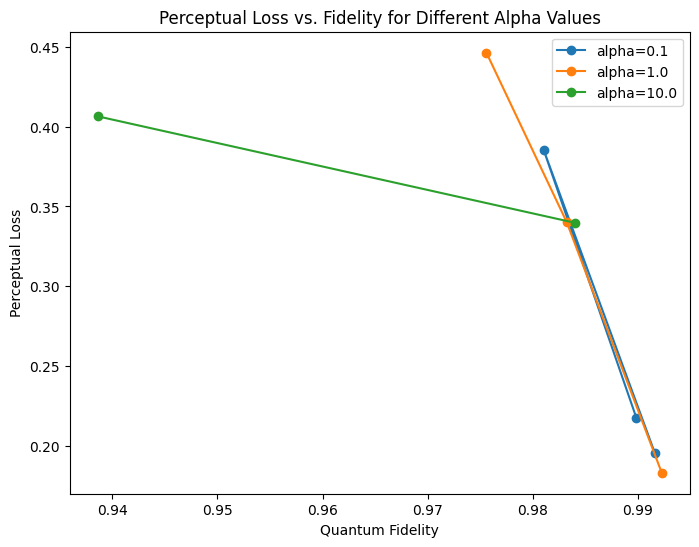


Best model parameters: alpha=1.0, beta=0.1


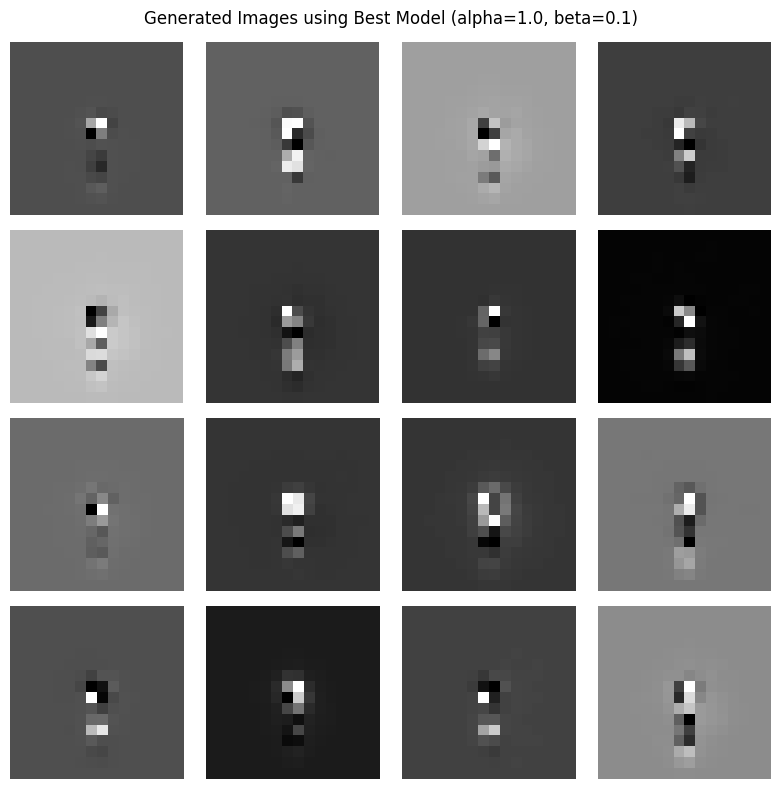

In [19]:
df_summary = pd.DataFrame(summary)
print("\nSummary of Results:")
print(df_summary)

# Plotting Perceptual Loss vs. Fidelity for different alpha and beta values
plt.figure(figsize=(8,6))
for alpha in alpha_values:
    df_alpha = df_summary[df_summary['alpha'] == alpha]
    plt.plot(df_alpha['fidelity'], df_alpha['perceptual_loss'], marker='o', label=f'alpha={alpha}')
plt.xlabel('Quantum Fidelity')
plt.ylabel('Perceptual Loss')
plt.title('Perceptual Loss vs. Fidelity for Different Alpha Values')
plt.legend()
plt.show()

# Visualize Generator Outputs for Best Model
# Find the model with lowest perceptual loss
best_model_key = min(results, key=lambda x: results[x]['perceptual_losses'][-1])
best_generator = results[best_model_key]['generator']

print(f"\nBest model parameters: alpha={best_model_key[0]}, beta={best_model_key[1]}")

# Generate and visualize images using the best generator
noise = torch.randn(16, n_qubits).to(device)
fake_data = best_generator(noise)
fake_data = fake_data.detach().cpu().numpy()

# Inverse PCA to reconstruct images
fake_data_pca = pca.inverse_transform(fake_data)
fake_images = fake_data_pca.reshape(-1, 1, 16, 16)